In [11]:
from tensorflow.keras import backend as K

def clear_memory():
    K.clear_session()
    tf.compat.v1.reset_default_graph()

In [12]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ensure reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Directories for normal and misbehavior images
normal_dir = '/home/UFAD/mohitkukreja/Documents/data_perfect_driving/images'
blurry_dir = '/home/UFAD/mohitkukreja/Documents/data_perfect_driving/images_blurred'
dirt_dir = '/home/UFAD/mohitkukreja/Documents/data_perfect_driving/images_dirt/'
tape_dir = '/home/UFAD/mohitkukreja/Documents/data_perfect_driving/images_tape/'

In [13]:
def load_and_preprocess_images(folder_path, num_images, target_size=(128, 128)):
    """Load and preprocess color images"""
    images = []
    count = 0
    for filename in os.listdir(folder_path):
        if count >= num_images:
            break
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = img_array / 255.0
            images.append(img_array)
            count += 1
    return np.array(images)

class Sampling(layers.Layer):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(models.Model):
    def __init__(self, input_shape, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder(input_shape)
        self.decoder = self.build_decoder()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_encoder(self, input_shape):
        encoder_inputs = layers.Input(shape=input_shape)
        x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
        x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
        x = layers.Flatten()(x)
        x = layers.Dense(512, activation='relu')(x)
        
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(x)
        z = Sampling()([z_mean, z_log_var])
        
        return models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

    def build_decoder(self):
        latent_inputs = layers.Input(shape=(self.latent_dim,))
        x = layers.Dense(16 * 16 * 128, activation='relu')(latent_inputs)
        x = layers.Reshape((16, 16, 128))(x)
        
        x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
        x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
        decoder_outputs = layers.Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
        
        return models.Model(latent_inputs, decoder_outputs, name='decoder')

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # Calculate reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            
            # Calculate KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(
                    1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                    axis=1
                )
            )
            
            total_loss = reconstruction_loss + 0.5 * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

def calculate_anomaly_score(model, images):
    """Calculate anomaly scores for given images"""
    z_mean, z_log_var, z = model.encoder(images)
    reconstructions = model.decoder(z)
    
    # Reconstruction error
    reconstruction_error = tf.reduce_mean(
        tf.square(images - reconstructions),
        axis=(1, 2, 3)
    )
    
    # KL divergence
    kl_divergence = -0.5 * tf.reduce_mean(
        1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
        axis=1
    )
    
    return reconstruction_error + 0.5 * kl_divergence

def plot_results(images, reconstructions, errors, threshold, category, num_samples=3):
    """Plot compact sample results"""
    fig, axes = plt.subplots(2, num_samples, figsize=(10, 4))
    predictions = errors > threshold
    
    # Find correct and incorrect predictions
    if category == 'Normal':
        correct_idx = np.where(~predictions)[0]
        incorrect_idx = np.where(predictions)[0]
    else:
        correct_idx = np.where(predictions)[0]
        incorrect_idx = np.where(~predictions)[0]
    
    # Plot samples
    for i in range(num_samples):
        idx = correct_idx[i] if i < len(correct_idx) else incorrect_idx[0]
        
        # Original
        axes[0, i].imshow(images[idx])
        axes[0, i].set_title(f'Original\nScore: {errors[idx]:.4f}')
        
        # Reconstruction
        axes[1, i].imshow(reconstructions[idx])
        axes[1, i].set_title('Reconstruction')
        
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    
    plt.suptitle(f'{category} Images Analysis')
    plt.tight_layout()
    plt.show()

Loading data...
Training VAE...
Epoch 1/50


2024-12-19 03:25:01.503956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-12-19 03:25:01.625990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-12-19 03:25:02.049883: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdaa8bdc310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-19 03:25:02.049913: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-19 03:25:02.049917: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-12-19 03:25:02.054232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-12-19 

250/250 [==============================] - 7s 12ms/step - loss: 11209.6317 - reconstruction_loss: 11103.3027 - kl_loss: 15.3994 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 2/50
250/250 [==============================] - 3s 11ms/step - loss: 10892.4396 - reconstruction_loss: 10828.6387 - kl_loss: 26.4942 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 3/50
250/250 [==============================] - 3s 11ms/step - loss: 10768.5486 - reconstruction_loss: 10733.9062 - kl_loss: 39.1074 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 4/50
250/250 [==============================] - 3s 11ms/step - loss: 10722.2085 - reconstruction_loss: 10692.0312 - kl_loss: 47.2991 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 5/50
250/250 [==============================] - 3s 11ms/step - loss: 10700.90

250/250 [==============================] - 3s 11ms/step - loss: 10629.7254 - reconstruction_loss: 10608.0508 - kl_loss: 45.7798 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 37/50
250/250 [==============================] - 3s 11ms/step - loss: 10632.2558 - reconstruction_loss: 10607.4033 - kl_loss: 45.4562 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 38/50
250/250 [==============================] - 3s 11ms/step - loss: 10629.4510 - reconstruction_loss: 10606.7666 - kl_loss: 45.5565 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 39/50
250/250 [==============================] - 3s 11ms/step - loss: 10628.8657 - reconstruction_loss: 10606.2324 - kl_loss: 45.2378 - val_total_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_kl_loss: 0.0000e+00
Epoch 40/50
250/250 [==============================] - 3s 11ms/step - loss: 1062

/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


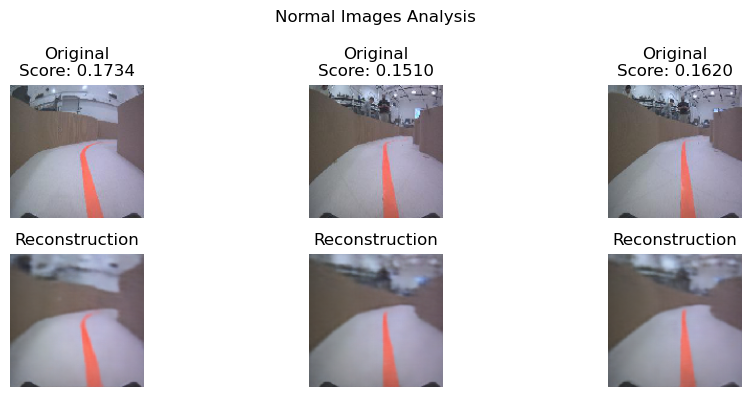


Blurry Images Analysis:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.01      0.03       500

    accuracy                           0.01       500
   macro avg       0.50      0.01      0.01       500
weighted avg       1.00      0.01      0.03       500



/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


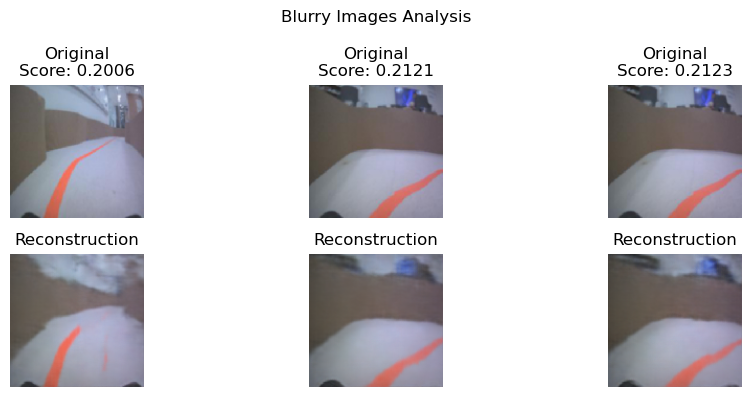

Detection Statistics:
- Images misclassified as normal: 493/500
- Anomaly Detection Rate: 1.40%

Taped Images Analysis:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.01      0.02       500

    accuracy                           0.01       500
   macro avg       0.50      0.00      0.01       500
weighted avg       1.00      0.01      0.02       500



/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/apps/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


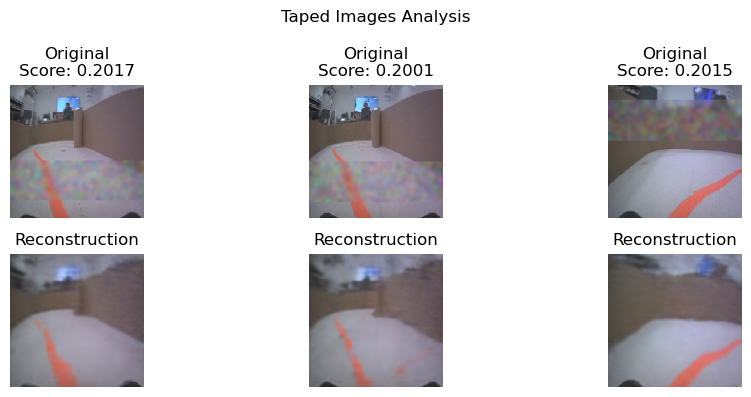

Detection Statistics:
- Images misclassified as normal: 496/500
- Anomaly Detection Rate: 0.80%

Dirty Images Analysis:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00       500

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



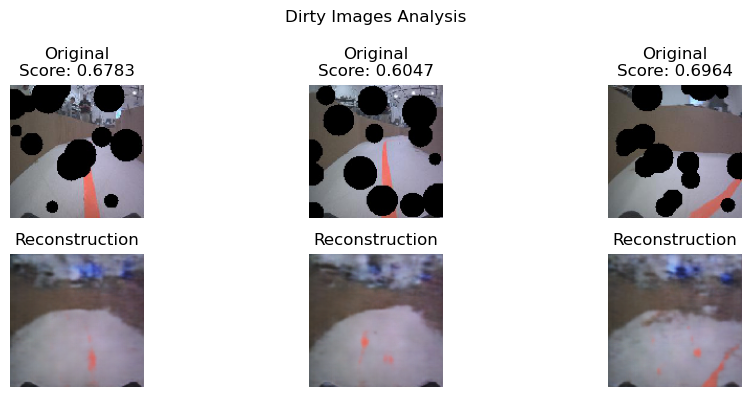

Detection Statistics:
- Images misclassified as normal: 0/500
- Anomaly Detection Rate: 100.00%


In [14]:
def main():
    # Load data
    print("Loading data...")
    normal_train = load_and_preprocess_images(normal_dir, 10000)
    normal_test = load_and_preprocess_images(normal_dir, 500)
    blurry_images = load_and_preprocess_images(blurry_dir, 500)
    taped_images = load_and_preprocess_images(tape_dir, 500)
    dirty_images = load_and_preprocess_images(dirt_dir, 500)

    # Create and compile VAE
    vae = VAE(normal_train[0].shape)
    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))

    # Train VAE
    print("Training VAE...")
    history = vae.fit(
        normal_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )

    # Calculate threshold using normal test data
    normal_scores = calculate_anomaly_score(vae, normal_test)
    threshold = np.percentile(normal_scores, 95)

    # Evaluate each category
    categories = {
        'Normal': normal_test,
        'Blurry': blurry_images,
        'Taped': taped_images,
        'Dirty': dirty_images
    }

    print("\nEvaluation Results:")
    print("-" * 50)

    for category, images in categories.items():
        # Get predictions and scores
        reconstructions = vae(images)
        anomaly_scores = calculate_anomaly_score(vae, images)
        predictions = anomaly_scores > threshold
        
        # Calculate metrics
        true_labels = np.zeros(len(predictions)) if category == 'Normal' else np.ones(len(predictions))
        
        print(f"\n{category} Images Analysis:")
        print(classification_report(true_labels, predictions))
        
        # Plot results
        plot_results(images, reconstructions, anomaly_scores, threshold, category)
        
        if category != 'Normal':
            incorrect = np.sum(~predictions)
            detection_rate = ((len(predictions)-incorrect)/len(predictions))*100
            print(f"Detection Statistics:")
            print(f"- Images misclassified as normal: {incorrect}/{len(predictions)}")
            print(f"- Anomaly Detection Rate: {detection_rate:.2f}%")

if __name__ == "__main__":
    main()